# Creating MobileNetV3 Neural Network from scratch

## Loading the [Data](https://pytorch.org/docs/stable/_modules/torchvision/datasets/cifar.html#CIFAR10) and looking into it

На этом этапе мы загрузим датасэт CIFAR10 и быстро изучим его. 

Стандартная процедура:

In [2]:
# 1 time download of torchvisoin into our environment
#! pip install torchvision

In [3]:
import numpy as np
import torch
from torchvision import utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor (png to tensor and normalization) 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))     #means and std dev for the CIFAR10 dataset
    ])

# downloading training and testing datasets from torchvision and saving them in /data directory
train_data = datasets.CIFAR10(root ='data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [5]:
len(train_data)

50000

In [6]:
set(train_data.targets)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [7]:
# WHY DOESNT THIS WORK ?
#train_data.targets.bincount()

In [8]:
# a little investigation into our data

sample = next(iter(train_data))
image, label = sample
image.shape

torch.Size([3, 32, 32])

image has 3 channels with 32 by 32 pixels

In [9]:
batch = next(iter(train_loader))
images, labels = batch
images.shape

torch.Size([20, 3, 32, 32])

In [10]:
import matplotlib.pyplot as plt

labels:  tensor([1, 3, 0, 4, 9, 5, 5, 0, 0, 5, 9, 2, 9, 3, 2, 6, 9, 1, 0, 4])


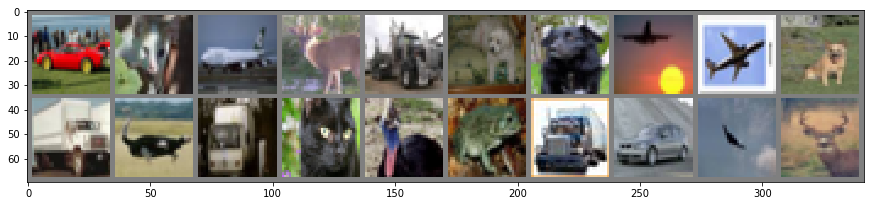

In [11]:
grid = utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid/2+0.5, (1,2,0)))
print('labels: ', labels)

## HERE WE WILL TRY TO IMPLEMENT OUR FIRST BASIC NEURAL NETWORK (MOBILENETV1)

To create Depthwise/ Separable layers we use this [thread](https://discuss.pytorch.org/t/depthwise-and-separable-convolutions-in-pytorch/7315). It states:

"for Depthwise / Separable, you can use Conv’s groups parameter.

http://pytorch.org/docs/master/nn.html#conv2d 2.5k

If groups = nInputPlane, then it is Depthwise. If groups = nInputPlane, kernel=(K, 1), (and before is a Conv2d layer with groups=1 and kernel=(1, K)), then it is separable."

### Hence first we create Depthwise and 1x1 blocks

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
# here we create a class of depthwise convolution layer
class depthwise_conv(nn.Module):
    def __init__(self, n_in, kernel_size, padding, bias=False, stride=1):
        super(depthwise_conv, self).__init__()
        #The trick here is to set number of in, number of filters = n_in, and set parameter groups to nInputPlane
        self.depthwise = nn.Conv2d(n_in, n_in, kernel_size = kernel_size, stride = stride, padding = padding, groups = n_in, bias = bias)
        
    def forward(self, x):
        out = self.depthwise(x)
        return out

In [13]:
# here we create a block of depthwise with all the usual transformations (a block)
class depthwise_block(nn.Module):
    def __init__(self, n_in, kernel_size, padding=1, bias=False, stride=1):
        super(depthwise_block, self).__init__()
        self.dw_block = nn.Sequential(
            depthwise_conv(n_in, kernel_size, padding, bias, stride),
            nn.BatchNorm2d(n_in),
            nn.ReLU(True)
        )
    
    def forward(self, x):
        out = self.dw_block(x)
        return x

In [29]:
# not sure how to perform it ???? DOUBLE CHECK TOMORROW                      <=================== DO NOT FORGET
class one_by_one_block(nn.Module):
    def __init__(self, n_in, n_out, padding=1, bias=False, stride=1):
        super(one_by_one_block, self).__init__()
        self.obo_block = nn.Sequential(
            nn.Conv2d(n_in, n_out, kernel_size = 1, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(n_out),
            nn.ReLU(True)
        ) 
    
    def forward(self, x):
        out = self.obo_block(x)
        return out

In [30]:
#defining the MNV1 architecture
class MobileNetV1(nn.Module):
    def __init__(self, input_channel, num_classes=10):
        super(MobileNetV1, self).__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(input_channel, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            depthwise_block(32, kernel_size=3),
            one_by_one_block(32, 64),
            
            depthwise_block(64, kernel_size=3, stride=2),
            one_by_one_block(64, 128),
            
            depthwise_block(128, kernel_size=3),
            one_by_one_block(128, 128),
            
            depthwise_block(128, kernel_size=3, stride=2),
            one_by_one_block(128, 256),
            
            depthwise_block(256, kernel_size=3),
            one_by_one_block(256, 256),
            
            depthwise_block(256, kernel_size=3, stride=2),
            one_by_one_block(256, 512),
            
            # 5 times 
            depthwise_block(512, kernel_size=3),
            one_by_one_block(512, 512),
            depthwise_block(512, kernel_size=3),
            one_by_one_block(512, 512),
            depthwise_block(512, kernel_size=3),
            one_by_one_block(512, 512),
            depthwise_block(512, kernel_size=3),
            one_by_one_block(512, 512),
            depthwise_block(512, kernel_size=3),
            one_by_one_block(512, 512),
            
            depthwise_block(512, kernel_size=3, stride=2),
            one_by_one_block(512, 1024),
            
            depthwise_block(1024, kernel_size=3, stride=2),
            one_by_one_block(1024, 1024),
        )
                
        self.linear = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        body_output = self.network(x)
        
        avg_pool_output = F.adaptive_avg_pool2d(body_output, (1, 1))
        avg_pool_flat = avg_pool_output.view(avg_pool_output.size(0), -1)

        output = self.linear(avg_pool_flat)
        
        return output

In [31]:
mob_net = MobileNetV1(3, 10)

### Now we have encountered some error, that was crashing our kernel. After some research we try this to avoid the error:

In [17]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

#conda install nomkl

In [18]:
# create predicitons using our network. Basically use feedforward of the data in our function
preds = mob_net(images)

IT WORKED !!!!!

Now we calculate the loss:

In [19]:
# calculating our cross-entropy file
loss = F.cross_entropy(preds, labels)
loss.item()
# because preds tensor was made with our mob_net, it has acceess to all the weights in our nn

2.3108115196228027

In [20]:
print(mob_net.linear.weight.shape)

torch.Size([10, 1024])


In [21]:
# backpropagation to calculate the gradients loss, has acces to all the weihgts in our nn...
loss.backward()

In [22]:
# now we check the wi 
mob_net.linear.weight.grad.shape

torch.Size([10, 1024])

In [23]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(mob_net.parameters(), lr=0.01)

In [24]:
#still same
loss.item()

2.3108115196228027

In [25]:
# quickly calculating how many labels were correct
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [26]:
get_num_correct(preds, labels)

1

In [30]:
optimizer.step() #updating weights inside the mob_net useing the optimizer SGD, and it's access to params of our nn

In [31]:
# second time predicting
preds = mob_net(images)
loss = F.cross_entropy(preds, labels)

In [32]:
loss.item()

2.240715265274048

In [33]:
get_num_correct(preds, labels)

3

In [34]:
# backpropagation to calculate gradients
loss.backward()

In [35]:
# updating weights
optimizer.step()

In [36]:
# third time predicting
preds = mob_net(images)
loss = F.cross_entropy(preds, labels)

In [37]:
loss.item()

2.1551318168640137

In [38]:
get_num_correct(preds, labels)

7

In [ ]:
#import torch.optim as optimizer

In [46]:
initial_lr = 0.045
torch.set_grad_enabled(True)

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [43]:
mob_net.to(device)

MobileNetV1(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): depthwise_block(
      (dw_block): Sequential(
        (0): depthwise_conv(
          (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        )
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (4): one_by_one_block(
      (obo_block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (5): depthwise_block(
      (dw_block): Sequential(
        (0): depthwise_conv(
          (depthwise): Conv2d(64, 64, ke

In [44]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mob_net.parameters(), lr=initial_lr, momentum=0.9)

for epoch in range(50):  
    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.SGD(mob_net.parameters(), lr=lr, momentum=0.9)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = mob_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #running_loss += loss.item()
        
        #show_period = 250
        #if i % show_period == show_period-1:    # print every "show_period" mini-batches
        #    print('[%d, %5d] loss: %.7f' %
        #          (epoch + 1, i + 1, running_loss / show_period))
        #    running_loss = 0.0
        
        
    total = 0
    correct = 0
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mob_net(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('[%d epoch] Accuracy of the network on the validation images: %d %%' % 
          (epoch, 100 * correct / total)
         )

print('Finished Training')


KeyboardInterrupt: 

In [49]:
import timeit
import time

### TRAINING WITH A SINGLE BATCH

F.Y.I Number of batches equals to number of times the weights of the nn will be updated

In [51]:
# timing 1 single batch training
start = time.time()

mobilenetV1_tester = MobileNetV1(3, 10)
optimizer = optim.SGD(mobilenetV1_tester.parameters(), lr = 0.045)

batch = next(iter(train_loader))
images, labels = batch

preds = mobilenetV1_tester(images)
loss = F.cross_entropy(preds, labels)

loss.backward()
optimizer.step()

end = time.time()
#================================================
print('Total elapsed time to train the single batch is: ', end-start)

print('loss_1: ', loss.item())
preds = mobilenetV1_tester(images)
loss = F.cross_entropy(preds, labels)
print('loss_2: ', loss.item())

elapsed time to train the single batch is:  22.720505714416504
loss_1:  2.3029165267944336
loss_2:  2.1164441108703613


All seems to work

In [57]:
# timing 1 full epoch training


mobilenetV1_tester = MobileNetV1(3, 10)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
optimizer = optim.SGD(mobilenetV1_tester.parameters(), lr = 0.045)

total_loss = 0
total_correct = 0

start = time.time()
for batch in train_loader: # get a batch
    images, labels = batch

    preds = mobilenetV1_tester(images)
    loss = F.cross_entropy(preds, labels)

    optimizer.zero_grad()    #make sure 0 out all the gradients that currently exist
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)

end = time.time()

print('epoch:', 0, "total_correct:", total_correct, "loss", total_loss)
print('Total elapsed time to train the single batch is: ', end-start)

KeyboardInterrupt: 

In [ ]:
total_correct/len(train_set)

In [ ]:
mobilenetV1 = MobileNetV1(3, 10)

number_epochs = 100

optimizer = optim.SGD(mobilenetV1.parameters(), lr = 0.045)

total_loss = 0
total_correct = 0

start = time.time()
for epoch in range(number_epochs)
    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.SGD(mobilenetV1.parameters(), lr=lr, momentum=0.9)
    
    for batch in train_loader: # get a batch
        
        images, labels = batch
        #inputs, labels = inputs.to(device), labels.to(device)

        preds = mobilenetV1(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()    #make sure 0 out all the gradients that currently exist
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)
    #print('epoch:', epoch, "total_correct:", total_correct, "loss", total_loss)
    
    total = 0
    correct = 0
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        #inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('[%d epoch] Accuracy of the network on the validation images: %d %%' % 
          (epoch, 100 * correct / total)
         )
    
end = time.time()
print('Finished Training')
print('Total elapsed time: ', end-start)

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

# print images
#imshow(torchvision.utils.make_grid(images))
#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(64)))
outputs = mobilenetV1(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(64)))

In [ ]:
#train_on_gpu = False

In [ ]:
#import torch.optim as optim

# specify loss function (categorical cross-entropy)
#criterion = nn.CrossEntropyLoss()

# specify optimizer
#optimizer = optim.SGD(mob_net.parameters(), lr=0.01)

In [16]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [17]:
def _make_divisible(v, divisor=8, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

# this function here works as a linear approximation of sigmoid (hard sigmoid)
class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)
        
    def forward(self, x):
        out = self.relu(x + 3)/6
        return out
    
    
# this function is a linear approximation of swish (hard swish)
class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)
        
    def forward(self, x):
        out = x*self.sigmoid(x)
        return out

    
# attempting to create squeeze-and-excite layer
class SE_layer(nn.Module):
    def __init__(self, exp_size, divide=4):
        super(SE_layer, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(exp_size, exp_size//divide),
            nn.ReLU(inplace=True),
            nn.Linear(exp_size // divide, exp_size),
            h_sigmoid()
        )
        
    def forward(self, x):
        batch, channels, height, width = x.size()
        out = F.avg_pool2d(x, kernel_size=[height, width]).view(batch, -1)
        out = self.dense(out)
        out = out.view(batch, channels, 1, 1)
        out = out*x
        return out


class MobileBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernal_size, stride, activation_function,exp_size): # RENAME THESE PARAMETERS
        super(MobileBlock, self).__init__()
        
        self.out_channels = out_channels
        self.activation_function = activation_function
        # WHAT IS THIS HERE ??????????????                        <============================== ??????????????
        padding = (kernal_size - 1) // 2
        
        #making sure that the ??????????????????                        <====================== HOW TO MAKE THIS
        self.connection = (stride == 1 and in_channels == out_channels)

        if self.activation_function == "RE":
            activation = nn.ReLU
        else:
            activation = h_swish

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, exp_size, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(exp_size),
            activation(inplace=True)
        )
        self.depth_conv = nn.Sequential(
            nn.Conv2d(exp_size, exp_size, kernel_size=kernal_size, stride=stride, padding=padding, groups=exp_size),
            nn.BatchNorm2d(exp_size),
        )

        self.point_conv = nn.Sequential(
            nn.Conv2d(exp_size, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            activation(inplace=True)
        )
        
    
    def forward(self, x):
        # Taken from MobileNetV2
        out = self.conv(x)
        out = self.depth_conv(out)
        out = self.point_conv(out) # point-wise conv

        # connection
        if self.connection:
            return x + out
        else:
            return out
        
        
        
# here is the Mobile block with the Squeeze and Excite Block
class MobileBlock_SE(nn.Module):
    def __init__(self, in_channels, out_channels, kernal_size, stride, activation_function, exp_size):
        super(MobileBlock_SE, self).__init__()
        
        self.out_channels = out_channels
        self.activation_function = activation_function
        
        padding = (kernal_size - 1) // 2

        self.connection = (stride == 1 and in_channels == out_channels)

        if self.activation_function == "RE":
            activation = nn.ReLU
        else:
            activation = h_swish

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, exp_size, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(exp_size),
            activation(inplace=True)
        )
        self.depth_conv = nn.Sequential(
            nn.Conv2d(exp_size, exp_size, kernel_size=kernal_size, stride=stride, padding=padding, groups=exp_size),
            nn.BatchNorm2d(exp_size),
        )

        self.squeeze_block = SE_layer(exp_size)

        self.point_conv = nn.Sequential(
            nn.Conv2d(exp_size, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            activation(inplace=True)
        )
        
        
    def forward(self, x):
        # taken from MobileNetV2
        out = self.conv(x)
        out = self.depth_conv(out)
        out = self.squeeze_block(out) # Squeeze and Excite
        out = self.point_conv(out) # point-wise conv

        # connection type
        if self.connection:
            return x + out
        else:
            return out
        
        


class MobileNetV3_large(nn.Module):
    def __init__(self, num_classes=10, multiplier=1.0, dropout_rate=0.0):
        super(MobileNetV3_large, self).__init__()
        self.num_classes = num_classes
        # what does the first line do and why is it here       ???????                 <==================
        init_conv_out = _make_divisible(16 * multiplier)
        
        # first layer
        self.init_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=init_conv_out, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(init_conv_out),
            h_swish(inplace=True)
        )
        
        self.block = nn.Sequential(
            MobileBlock(_make_divisible(16), _make_divisible(16), 3, 1, "RE", _make_divisible(16)),
            MobileBlock(_make_divisible(16), _make_divisible(24), 3, 2, "RE", _make_divisible(64)),
            MobileBlock(_make_divisible(24), _make_divisible(24), 3, 1, "RE", _make_divisible(72)),
            MobileBlock_SE(_make_divisible(24), _make_divisible(40), 5, 2, "RE", _make_divisible(72)),
            MobileBlock_SE(_make_divisible(40), _make_divisible(40), 5, 1, "RE", _make_divisible(120)),
            MobileBlock_SE(_make_divisible(40), _make_divisible(40), 5, 1, "RE", _make_divisible(120)),
            MobileBlock(_make_divisible(40), _make_divisible(80), 3, 2, "HS", _make_divisible(240)),
            MobileBlock(_make_divisible(80), _make_divisible(80), 3, 1, "HS", _make_divisible(200)),
            MobileBlock(_make_divisible(80), _make_divisible(80), 3, 1, "HS", _make_divisible(184)),
            MobileBlock(_make_divisible(80), _make_divisible(80), 3, 1, "HS", _make_divisible(184)),
            MobileBlock_SE(_make_divisible(80), _make_divisible(112), 3, 1, "HS", _make_divisible(480)),
            MobileBlock_SE(_make_divisible(112), _make_divisible(112), 3, 1, "HS", _make_divisible(672)),
            MobileBlock_SE(_make_divisible(112), _make_divisible(160), 5, 1, "HS", _make_divisible(672)),
            MobileBlock_SE(_make_divisible(160), _make_divisible(160), 5, 2, "HS", _make_divisible(672)),
            MobileBlock_SE(_make_divisible(160), _make_divisible(160), 5, 1, "HS", _make_divisible(960))
        )
        
        out_conv1_in = _make_divisible(160 * multiplier)
        out_conv1_out = _make_divisible(960 * multiplier)
        self.out_conv1 = nn.Sequential(
            nn.Conv2d(out_conv1_in, out_conv1_out, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_conv1_out),
            h_swish(inplace=True),
        )
        
        out_conv2_in = _make_divisible(960 * multiplier)
        out_conv2_out = _make_divisible(1280 * multiplier)
        self.out_conv2 = nn.Sequential(
            nn.Conv2d(out_conv2_in, out_conv2_out, kernel_size=1, stride=1),
            h_swish(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Conv2d(out_conv2_out, self.num_classes, kernel_size=1, stride=1),
        )
        

    def forward(self, x):
        out = self.init_conv(x)
        out = self.block(out)
        out = self.out_conv1(out)
        batch, channels, height, width = out.size()
        out = F.avg_pool2d(out, kernel_size=[height, width])
        out = self.out_conv2(out).view(batch, -1)
        
        return out
        

In [22]:
class MobileNetV3_large(nn.Module):
    """
    MobileNetV3_large model taken from Table 1, of the paper of interest
    """
    def __init__(self, num_classes=10, multiplier=1.0, dropout_rate=0.0):
        super(MobileNetV3_large, self).__init__()
        self.num_classes = num_classes
        init_conv_out = _make_divisible(16 * multiplier)

        # first layer
        self.init_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=init_conv_out, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(init_conv_out),
            h_swish(inplace=True)
        )

        self.block = nn.Sequential(
            MobileBlock(_make_divisible(16), _make_divisible(16), 3, 1, "RE", _make_divisible(16)),
            MobileBlock(_make_divisible(16), _make_divisible(24), 3, 2, "RE", _make_divisible(64)),
            MobileBlock(_make_divisible(24), _make_divisible(24), 3, 1, "RE", _make_divisible(72)),
            MobileBlock_SE(_make_divisible(24), _make_divisible(40), 5, 2, "RE", _make_divisible(72)),
            MobileBlock_SE(_make_divisible(40), _make_divisible(40), 5, 1, "RE", _make_divisible(120)),
            MobileBlock_SE(_make_divisible(40), _make_divisible(40), 5, 1, "RE", _make_divisible(120)),
            MobileBlock(_make_divisible(40), _make_divisible(80), 3, 2, "HS", _make_divisible(240)),
            MobileBlock(_make_divisible(80), _make_divisible(80), 3, 1, "HS", _make_divisible(200)),
            MobileBlock(_make_divisible(80), _make_divisible(80), 3, 1, "HS", _make_divisible(184)),
            MobileBlock(_make_divisible(80), _make_divisible(80), 3, 1, "HS", _make_divisible(184)),
            MobileBlock_SE(_make_divisible(80), _make_divisible(112), 3, 1, "HS", _make_divisible(480)),
            MobileBlock_SE(_make_divisible(112), _make_divisible(112), 3, 1, "HS", _make_divisible(672)),
            MobileBlock_SE(_make_divisible(112), _make_divisible(160), 5, 1, "HS", _make_divisible(672)),
            MobileBlock_SE(_make_divisible(160), _make_divisible(160), 5, 2, "HS", _make_divisible(672)),
            MobileBlock_SE(_make_divisible(160), _make_divisible(160), 5, 1, "HS", _make_divisible(960))
        )

        out_conv1_in = _make_divisible(160 * multiplier)
        out_conv1_out = _make_divisible(960 * multiplier)
        self.out_conv1 = nn.Sequential(
            nn.Conv2d(out_conv1_in, out_conv1_out, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_conv1_out),
            h_swish(inplace=True),
        )

        out_conv2_in = _make_divisible(960 * multiplier)
        out_conv2_out = _make_divisible(1280 * multiplier)
        self.out_conv2 = nn.Sequential(
            nn.Conv2d(out_conv2_in, out_conv2_out, kernel_size=1, stride=1),
            h_swish(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Conv2d(out_conv2_out, self.num_classes, kernel_size=1, stride=1),
        )


    def forward(self, x):
        out = self.init_conv(x)
        out = self.block(out)
        out = self.out_conv1(out)
        batch, channels, height, width = out.size()
        out = F.avg_pool2d(out, kernel_size=[height, width])
        out = self.out_conv2(out).view(batch, -1)

        return out



In [23]:
MobileNetV3_large_test = MobileNetV3_large(num_classes = 10)

In [24]:
import time

In [ ]:
# timing 1 single batch training
start = time.time()

MobileNetV3_large_test = MobileNetV3_large(10)
optimizer = optim.SGD(MobileNetV3_large_test.parameters(), lr = 0.045)

batch = next(iter(train_loader))
images, labels = batch

preds = MobileNetV3_large_test(images)
loss = F.cross_entropy(preds, labels)

loss.backward()
optimizer.step()

end = time.time()
#================================================
print('Total elapsed time to train the single batch is: ', end-start)

print('loss_1: ', loss.item())
preds = MobileNetV3_large_test(images)
loss = F.cross_entropy(preds, labels)
print('loss_2: ', loss.item())